In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import math
import os

# UTILS

In [23]:
def features_labels(file, scale=True):
    dataset = torch.load(file)
    features = np.asarray(dataset['features'])
    if scale is True:
        features = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-9)
    labels = np.asarray(dataset['labels'])
    return features, labels

def name_features(n_features):
    stat = ['MEAN', 'STD', 'MAX', 'MIN']
    hist = ['BIN_' + str(i) for i in range(4)]
    glcm = []
    for prop in ['CON', 'HOM', 'ENG', 'COR', 'ENT']:
        for d in [1, 4, 8]:
            for th in ['0', 'Pi/4', 'Pi/2', '3Pi/4']:
                glcm += [prop + '_' + str(d) + '_' + th]
    return np.concatenate([stat, hist, glcm])

def delete_noise(features, labels, std):
    ''' DELETE SAMPLES WITH NOISE DATA (FEACH VAL != [std, +std]) '''
    ind = np.where((features < -1 * std) | (features > std))[0]
    features = np.delete(features, ind, axis=0)
    labels = np.delete(labels, ind)
    return features, labels

def load_features(file, a, b, std=3, scale=True):
    ''' Загрузка и стандартизация '''
    features, labels = features_labels(file, scale=scale)
    n_features = len(features[0])
    before = len(features)
    features = features[:, a:b]
    print(f'SRC features shape: {features.shape}')
    
    '''Удаление шумов в 3std'''
    features, labels = delete_noise(features, labels, std)
    print(f'Shape after delete noise: {features.shape}')
    
    delta = int((1-features.shape[0]/before)*1000)/10.
    labels = list(labels)
    delta_per_class = [int((labels.count(i)/844*1000)/10) for i in range(6)]
    print(f'{delta}% дальше, чем {std}std')
    print(f'{delta_per_class} % по классам')
    return features, labels

def transform_features(x, length, is_all):
    x = x.copy()
    indices = list(range(8)) if is_all else []
    if length == 'long':
        return x
    elif length == 'middle':
        for i in range(0, 60, 12):
            indices += list(range(i, i + 4))
        x = x[:, indices]
    elif length == 'short':
        for i in range(0, 60, 12):
            ind = list(range(i, i + 4))
            x[:, i] = np.mean(x[:, ind], axis=1)
            indices += [i]
        x = x[:, indices]
    else:
        raise ValueError(f'Arg \'length\'={length} is not valid. Must be [\'long\', \'middle\', \'short\']')
    return x

In [24]:
def plot_cos_matrix(cos):
    with_theta = cos.shape[0] == 72 
    cos = np.triu(cos).transpose()
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 12)
    a = ax.imshow(cos, cmap='Blues')
    fig.colorbar(a)
    
    classes = ['Bacterial spot', 'Early blight', 'Healthy', 'Late blight', 'Septoria', 'Yellow Virus']
    if with_theta: 
        for i in range(0, 73, 12):
            ax.vlines(i-0.5, 0-0.5 + i, 72-0.5, color='k', linewidth=2)
            ax.hlines(i-0.5, 0-0.5, 72-0.5 - (72- i), color='k', linewidth=2)
    else: 
        for i in range(0, 18, 3):
            ax.vlines(i-0.5, 0-0.5 + i, 18-0.5, color='k', linewidth=2)
            ax.hlines(i-0.5, 0-0.5, 18-0.5 - (18- i), color='k', linewidth=2)
    
    xticks = []
    xticks_minor = []
    yticks_minor = []
    labels = []
    labels_minor = []
    va = []
    d = [1, 4, 8]
    rng = range(0, 72, 4) if with_theta else range(0, 18)
    c = 12 if with_theta else 3
    
    for i in rng:
        d_ = (1 if i % 12 == 0 else i) if with_theta else d[i%3]
        xticks += [(i-0.5) if with_theta else i] 
        labels += [(f'd={d_%12}') if with_theta else d_]
        if i % c is 0:
            va += [-0.03]
            xticks_minor += [(i+6) if with_theta else i + 0.999] 
            pad = i + (1.5 * 12 / len(classes[(i)//12])) if with_theta else i + 3 / len(classes[(i)//3])
            yticks_minor += [pad] 
            labels_minor += [classes[(i)//c]]
            
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_xticks(xticks_minor, minor=True)
    ax.set_xticklabels(labels_minor, minor=True)
    ax.tick_params( axis='x', which='minor', length=0)
    
    ax.set_yticks(xticks)
    ax.set_yticklabels(labels)
    ax.set_yticks(yticks_minor , minor=True)
    ax.set_yticklabels(labels_minor, minor=True)
    ax.tick_params( axis='y', which='major', rotation=90)
    ax.tick_params( axis='y', which='minor', length=0, rotation=90, pad=25)
    
    [xtick.set_y(y) for xtick, y in zip(ax.get_xticklabels(minor=True), va)]

In [25]:
def plot_cos_vector(cos):
    m=[]
    for i in range(len(cos)):
        g = i // 12
        cos[i][12*g: 12*g+12]=0
        m += [np.sum(cos[i]) / (72-12)]
#     m = np.mean(np.abs(cos), axis=1)
    df = pd.DataFrame(m)
    df.columns = ['Косинусное сходство']
    names = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']

    classes, d, phi = [], [], []
    for name in names:
        for i in [1, 4 ,8]:
            for j in ['0', 'π/4', 'π/2', '3π/4']:
                d += [i]
                phi += [j]
                classes += [name]
    df['Класс'] = pd.Series(classes, index=df.index)
    df['Расстояние, d'] = pd.Series(d, index=df.index)
    df['Направление, φ'] = pd.Series(phi, index=df.index)


    cmap = sns.color_palette("Blues_d", 4)
    col =  ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
    sns.catplot(x='Расстояние, d', y="Косинусное сходство", col="Класс", hue='Направление, φ', data=df, 
                    kind="bar", aspect=.5, palette=cmap, legend=True)

In [26]:
def load_data(file, a=8, b=68, std=3):
    ''' Загрузка и стандартизация '''
    file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
    features, labels = features_labels(file, scale=True)
    n_features = len(features[0])
    before = len(features)
    features = features[:, a:b]
    print(f'SRC features shape: {features.shape}')

    '''Удаление шумов в 3std'''
    features, labels = delete_noise(features, labels, std)
    n_samples, n_features = features.shape
    n_classes = len(set(labels))
    print(f'Shape after delete noise: {features.shape}')

    delta = int((1-features.shape[0]/before)*1000)/10.
    labels = list(labels)
    delta_per_class = [int((labels.count(i)/844*1000)/10) for i in range(6)]
    print(f'{delta}% дальше, чем {std}std')
    print(f'{delta_per_class} % по классам')
    
    d = {l: [] for l in set(labels)}
    for f, l in zip(features, labels):
        d[l].append(f)

    min_len = min([len(d[i]) for i in d.keys()])
    data = np.zeros((n_classes, min_len, n_features))
    for i in d.keys():
        data[i] = d[i][:min_len]

    data = np.zeros((n_classes, min_len, n_features))
    for i in d.keys():
        data[i] = d[i][:min_len]
    return data

In [51]:
def LDA_CLASS(file, a, b, lenght, mode, is_all=False, std=3, scale=True, xticklabels=['-3σ', '-2σ', '-σ', '0', 'σ', '2σ', '3σ']): 
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\train\\R.pth') 
    features, labels = load_features(file, a, b, std, scale)
    features = transform_features(features, lenght, is_all)
    
    clf = LinearDiscriminantAnalysis(n_components=1)
    features=clf.fit_transform(features, labels)

    features = (features + std) / (2*std)
    classes = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria', 'Yellow_Virus']
    data = [[classes[l]] + list(f) for l, f in zip(labels, features)]
    df = pd.DataFrame.from_dict(data)
    names = np.concatenate([['Класс'], list(range(len(features[0])))])
    df.columns = names

    std = math.ceil(std)
    xlim = (-std, std)
    bins = list(range(-std, std+1))
    mean = 0.5
    std = 1. / 6.
    loc = np.full((len(bins),), mean) + np.asarray(bins) * std

    plt.clf()
    sns.set_context("talk", font_scale=1.1)
    hue_order =['Bacterial_spot', 'Healthy', 'Yellow_Virus', 'Late_blight', 'Septoria', 'Early_blight']
    g = sns.kdeplot(data=df, x='0', hue="Класс", hue_order=hue_order, fill=True) 
   
    old_legend = g.legend_
    handles = old_legend.legendHandles
    llabels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    g.legend(handles, llabels, loc='center', bbox_to_anchor= (1.35, 0.5), title=title)
    g.set(xticks=loc, xticklabels=xticklabels, xlim=(mean + std * (np.min(bins)-1), mean + std * (np.max(bins)+1)))
    
    plt.xlabel('')
    plt.ylabel('Вероятность')
    plt.title('LDA')
    plt.show()
    
    clfNB = GaussianNB().fit(features, labels)
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\test\\R.pth') 
    x_test, y_test = load_features(file, a, b, 5, True)
    x_test = transform_features(x_test, lenght, is_all)
    x_test = clf.transform(x_test)    
    predict = clfNB.predict(x_test)
    fscore = f1_score(y_test, predict, average='weighted')
    print('CLAS:', fscore)

In [41]:
def LDA_DETECT(file, a, b, lenght, mode, is_all=False, std=3, scale=True, xticklabels=['-3σ', '-2σ', '-σ', '0', 'σ', '2σ', '3σ']): 
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\train\\R.pth') 
    features, labels = load_features(file, a, b, std, scale)
    features = transform_features(features, lenght, is_all)
    
    clf = LinearDiscriminantAnalysis(n_components=1)
    features=clf.fit_transform(features, labels)

    features = (features + std) / (2*std)
    classes = ['Больные', 'Больные', 'Здоровые', 'Больные', 'Больные', 'Больные']
    data = [[classes[l]] + list(f) for l, f in zip(labels, features)]
    df = pd.DataFrame.from_dict(data)
    names = np.concatenate([['Класс'], list(range(len(features[0])))])
    df.columns = names

    std = math.ceil(std)
    xlim = (-std, std)
    bins = list(range(-std, std+1))
    mean = 0.5
    std = 1. / 6.
    loc = np.full((len(bins),), mean) + np.asarray(bins) * std

    plt.clf()
    sns.set_context("talk", font_scale=1.1)
    hue_order = ['Больные', 'Здоровые']    
    g = sns.kdeplot(data=df, x='0', hue="Класс", hue_order=hue_order, fill=True) 
   
    old_legend = g.legend_
    handles = old_legend.legendHandles
    llabels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    g.legend(handles, llabels, loc='center', bbox_to_anchor= (1.35, 0.5), title=title)
    g.set(xticks=loc, xticklabels=xticklabels, xlim=(mean + std * (np.min(bins)-1), mean + std * (np.max(bins)+1)))
    
    plt.xlabel('')
    plt.ylabel('Вероятность')
    plt.title('LDA')
    plt.show()
    
    clfNB = GaussianNB()
    labels = [0 if i == 2 else 1 for i in labels]
    clfNB.fit(features, labels)
    
    file = os.path.join(os.getcwd(), f'..\\data\\{mode}\\test\\R.pth') 
    x_test, y_test = load_features(file, a, b, 5, True)
    x_test = transform_features(x_test, lenght, is_all)
    y_test = [0 if i == 2 else 1 for i in y_test]
    x_test = clf.transform(x_test)
    print(x_test.shape, len(y_test))
    
    predict = clfNB.predict(x_test)
    fscore = f1_score(y_test, predict, average='weighted')
    print('DETECT:', fscore)

# GLOBAL

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 5, 3, 4)
(6, 3, 4, 5)
(72, 5)
(72, 72)


([<matplotlib.axis.YTick at 0x20f100bc6c8>,
 [Text(0, 0.5, 'd=1'), Text(0, 1.5, 'd=4'), Text(0, 2.5, 'd=8')])

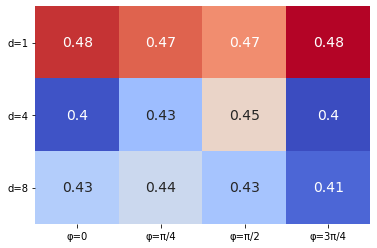

In [41]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.mean(d, axis=1)
print(d.shape)
d = np.transpose(d, (0, 2, 3, 1))
print(d.shape)
d = np.reshape(d, (-1, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

m=[]
for i in range(len(cos)):
    g = i // 12
    cos[i][12*g:12*g+12] = 0
    summ = 0
    k = i % 12
    for j in range(k, 72, 12):
        summ += cos[i][j]
    m += [summ / 5]
    df = pd.DataFrame(m)

m = np.reshape(m, (6, 3, 4))
m = np.mean(m, axis=0)
sns.heatmap(m, annot=True, annot_kws={"size": 14}, cmap='coolwarm', cbar=False)
plt.xticks(np.arange(0.5, 3.6, 1), ['φ=0', 'φ=π/4', 'φ=π/2', 'φ=3π/4'])
plt.yticks(np.arange(0.5, 2.6, 1), ['d=1', 'd=4', 'd=8'], rotation=0)

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


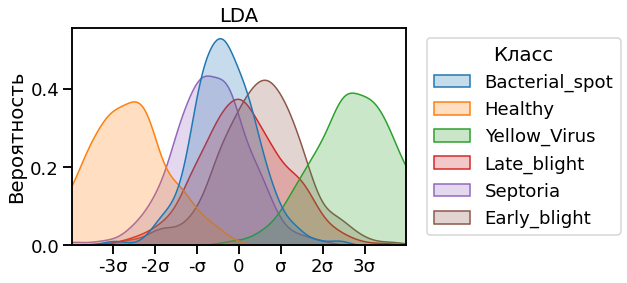

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.23086421207844834
SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


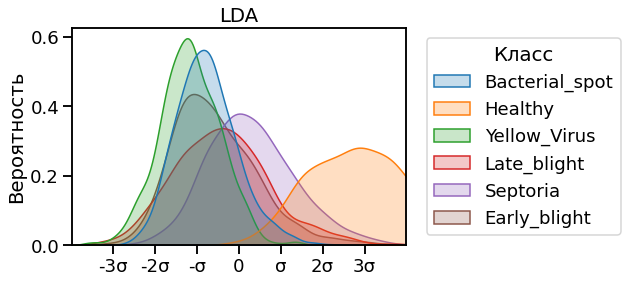

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.199213700034721
SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


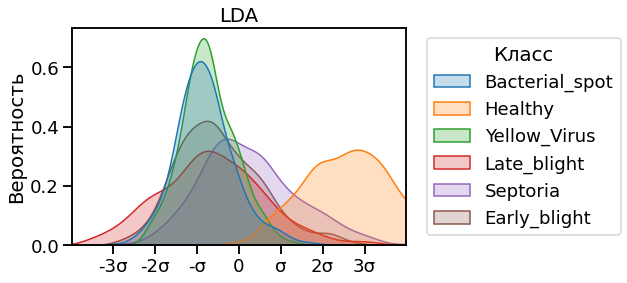

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.18066535983856952


In [42]:
LDA_CLASS(file, 8, 68, 'long', 'global')
LDA_CLASS(file, 8, 68, 'middle', 'global')
LDA_CLASS(file, 8, 68, 'short', 'global')

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


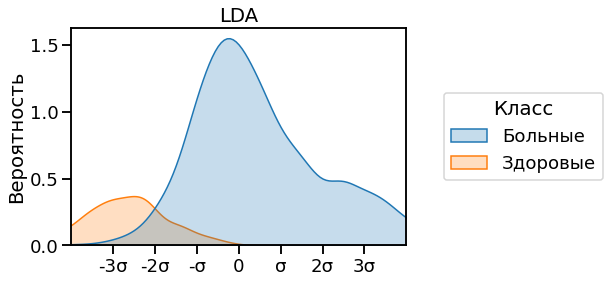

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(929, 1) 929
DETECT: 0.6431552597294763
SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


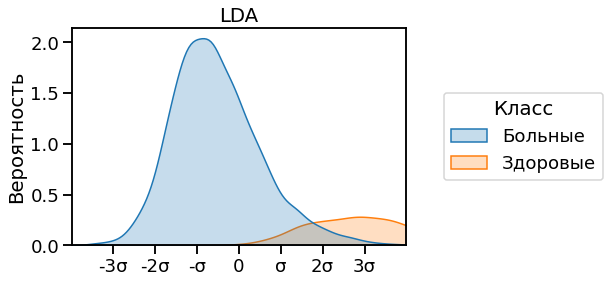

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(929, 1) 929
DETECT: 0.9077887246657084
SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам


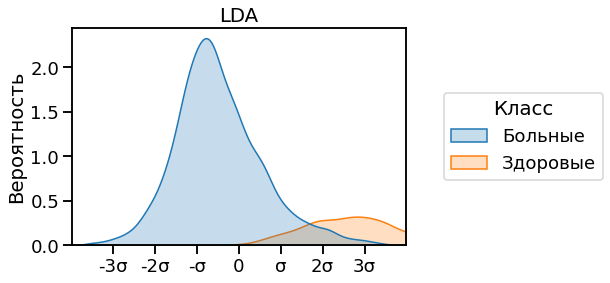

SRC features shape: (930, 60)
Shape after delete noise: (929, 60)
0.1% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(929, 1) 929
DETECT: 0.9012041988384103


In [43]:
LDA_DETECT(file, 8, 68, 'long', 'global')
LDA_DETECT(file, 8, 68, 'middle', 'global')
LDA_DETECT(file, 8, 68, 'short', 'global')

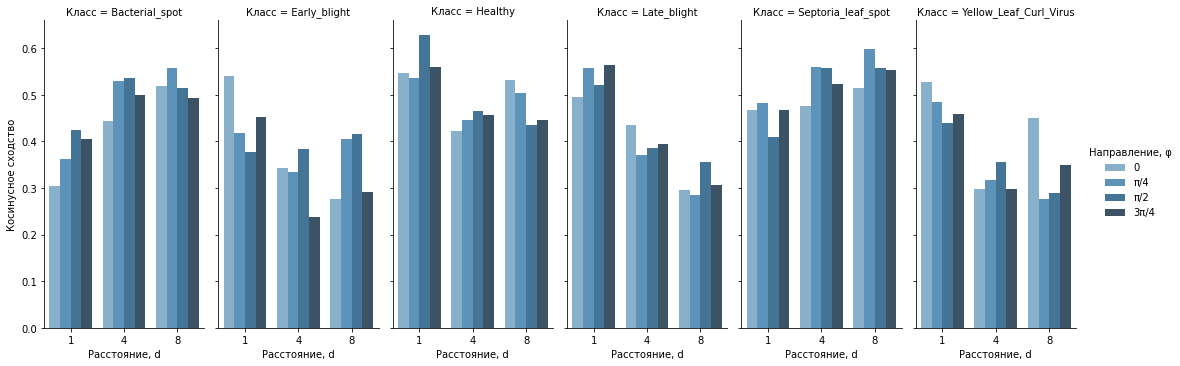

In [17]:
df.columns = ['Косинусное сходство']
names = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
classes, d, phi = [], [], []
for name in names:
    for i in [1, 4 ,8]:
        for j in ['0', 'π/4', 'π/2', '3π/4']:
            d += [i]
            phi += [j]
            classes += [name]
df['Класс'] = pd.Series(classes, index=df.index)
df['Расстояние, d'] = pd.Series(d, index=df.index)
df['Направление, φ'] = pd.Series(phi, index=df.index)
cmap = sns.color_palette("Blues_d", 4)
col =  ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
sns.catplot(x='Расстояние, d', y="Косинусное сходство", col="Класс", hue='Направление, φ', data=df, 
                kind="bar", aspect=.5, palette=cmap, legend=True)

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 5, 3, 4)
(6, 3, 4, 5)
(72, 5)
(72, 72)


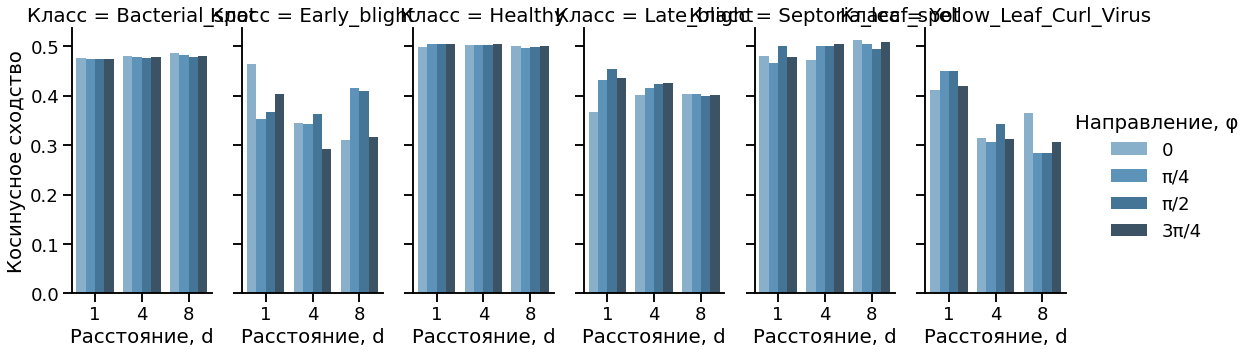

In [58]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.mean(d, axis=1)
print(d.shape)
d = np.transpose(d, (0, 2, 3, 1))
print(d.shape)
d = np.reshape(d, (-1, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

m=[]
for i in range(len(cos)):
    g = i // 12
    cos[i][12*g:12*g+12] = 0
    summ = 0
    k = i % 12
    for j in range(k, 72, 12):
        summ += cos[i][j]
    m += [summ / 5]
    df = pd.DataFrame(m)

# df.columns = ['Косинусное сходство']
# names = ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
# classes, d, phi = [], [], []
# for name in names:
#     for i in [1, 4 ,8]:
#         for j in ['0', 'π/4', 'π/2', '3π/4']:
#             d += [i]
#             phi += [j]
#             classes += [name]
# df['Класс'] = pd.Series(classes, index=df.index)
# df['Расстояние, d'] = pd.Series(d, index=df.index)
# df['Направление, φ'] = pd.Series(phi, index=df.index)
# cmap = sns.color_palette("Blues_d", 4)
# col =  ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Septoria_leaf_spot', 'Yellow_Leaf_Curl_Virus']
# sns.catplot(x='Расстояние, d', y="Косинусное сходство", col="Класс", hue='Направление, φ', data=df, 
#                 kind="bar", aspect=.5, palette=cmap, legend=True)

plot_cos_vector(cos)

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 5, 3, 4)
(6, 3, 4, 5)
(72, 5)
(72, 72)


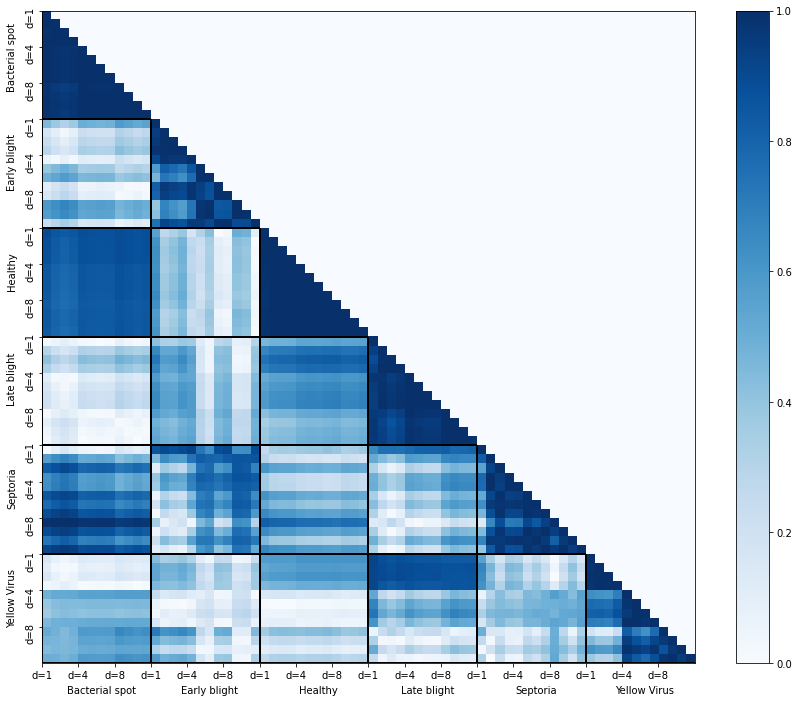

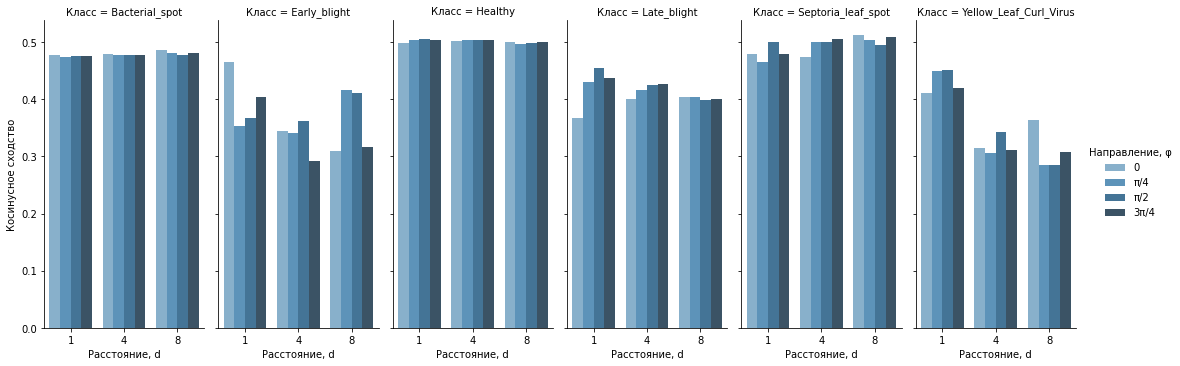

In [14]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.mean(d, axis=1)
print(d.shape)
d = np.transpose(d, (0, 2, 3, 1))
print(d.shape)
d = np.reshape(d, (-1, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

plot_cos_matrix(cos)
plot_cos_vector(cos)

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 3, 4, 5, 745)
(6, 3, 4, 5)
(72, 5)
(72, 72)


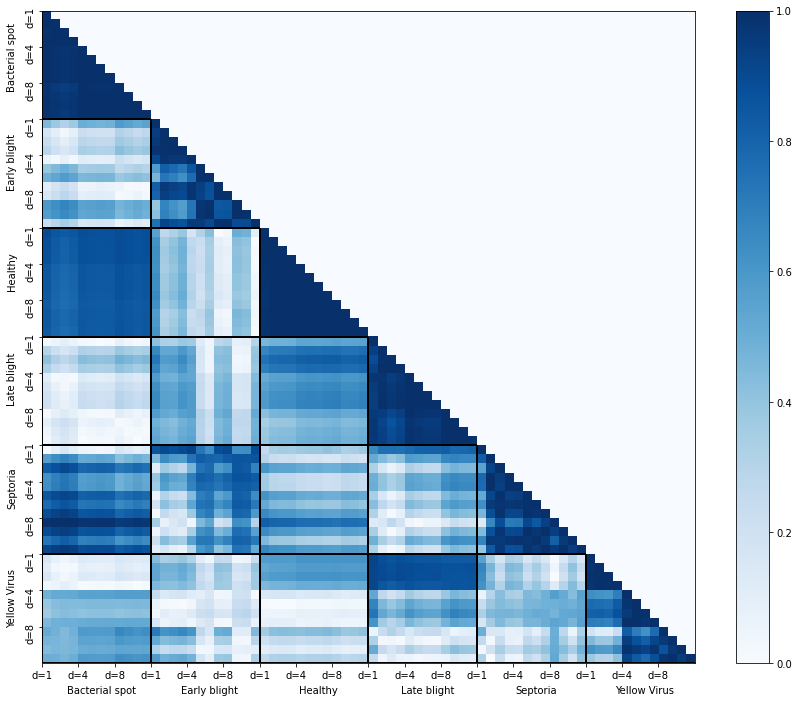

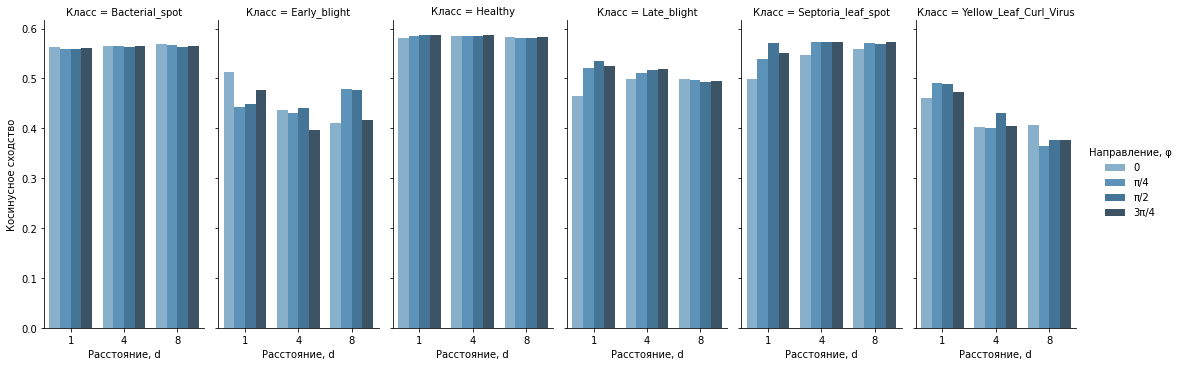

In [7]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.transpose(d, (0, 3, 4, 2, 1))
print(d.shape)
d = np.mean(d, axis=4)
print(d.shape)
d = np.reshape(d, (6*3*4, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

plot_cos_matrix(cos)
plot_cos_vector(cos)

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 3, 5, 4, 745)
(6, 3, 5)
(18, 5)
(18, 18)


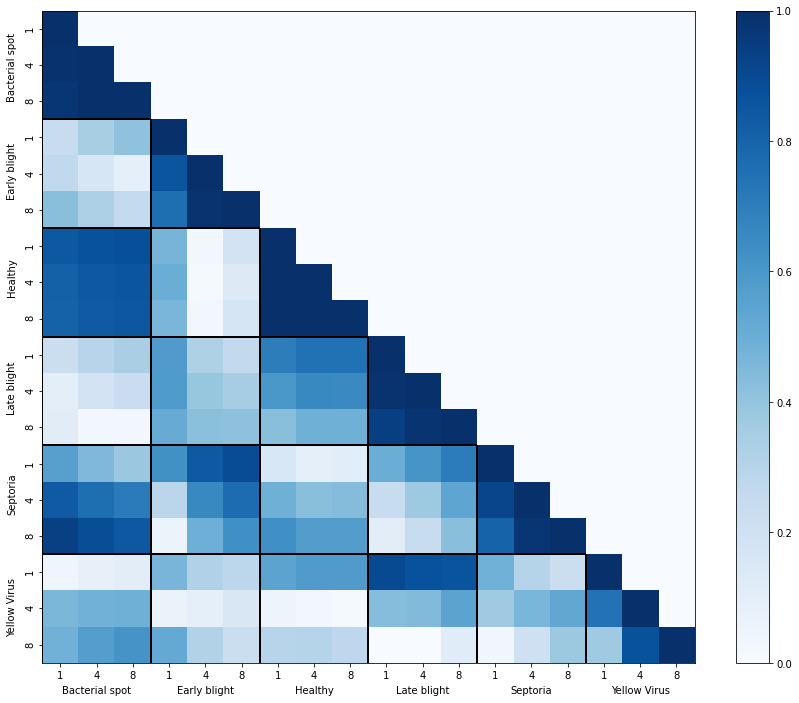

In [379]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.transpose(d, (0, 3, 2, 4, 1))
print(d.shape)
d = np.mean(d, axis=(-1, -2))
print(d.shape)
d = np.reshape(d, (6*3, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

plot_cos_matrix(cos)

# LOCAL

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 3, 4, 5, 745)
(6, 3, 4, 5)
(72, 5)
(72, 72)


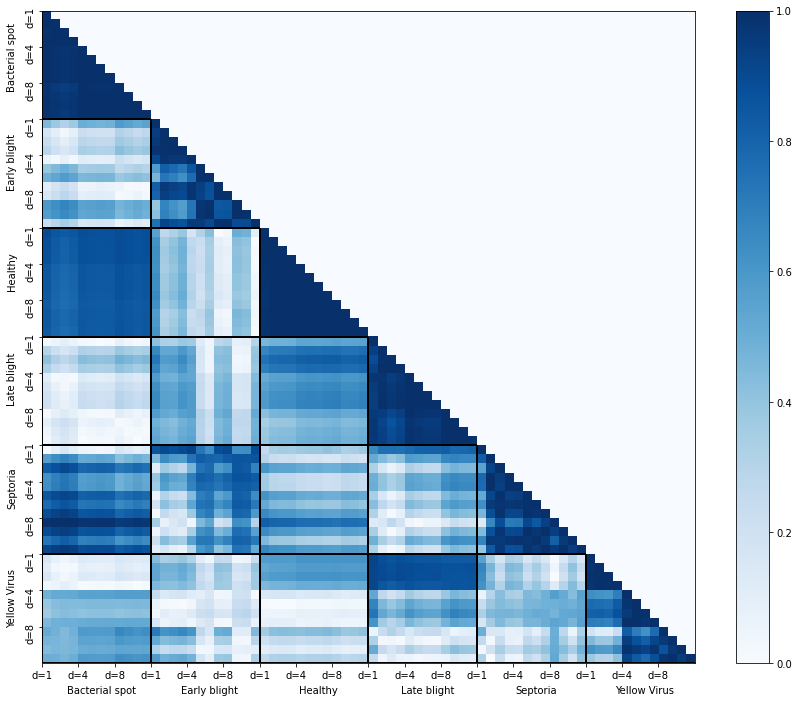

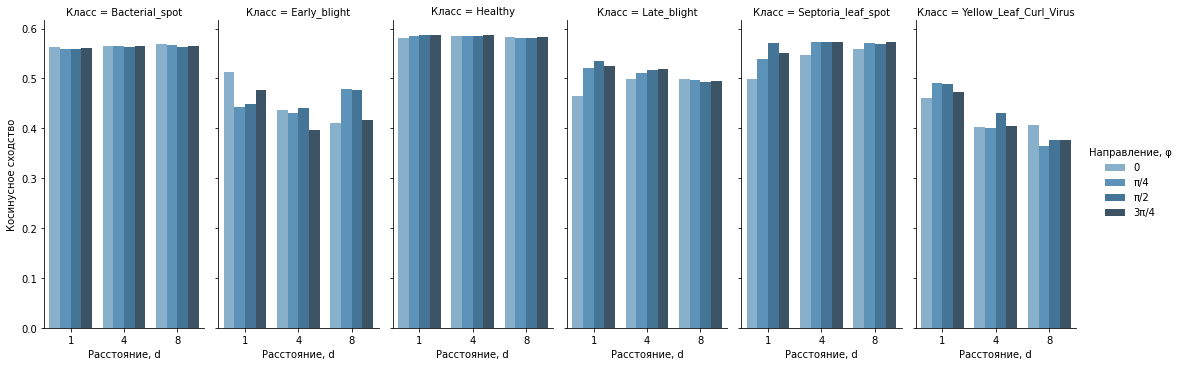

In [381]:
file = os.path.join(os.getcwd(), '..\\data\\local\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.transpose(d, (0, 3, 4, 2, 1))
print(d.shape)
d = np.mean(d, axis=4)
print(d.shape)
d = np.reshape(d, (6*3*4, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

plot_cos_matrix(cos)
plot_cos_vector(cos)

SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


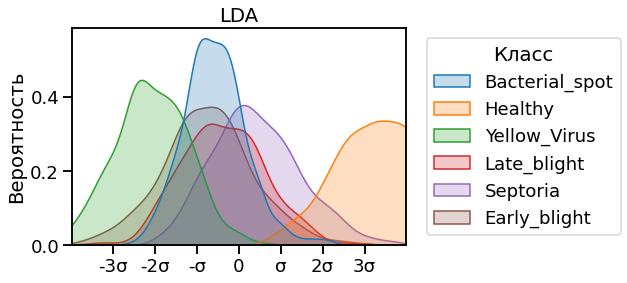

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.2136924622003113
SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


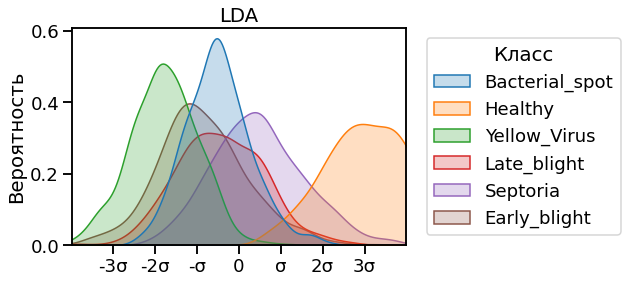

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.22303656066525404
SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


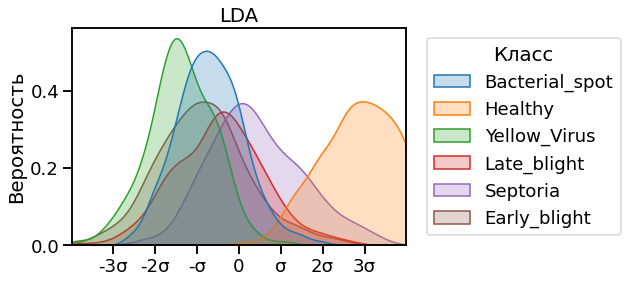

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.21160433721937255
SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


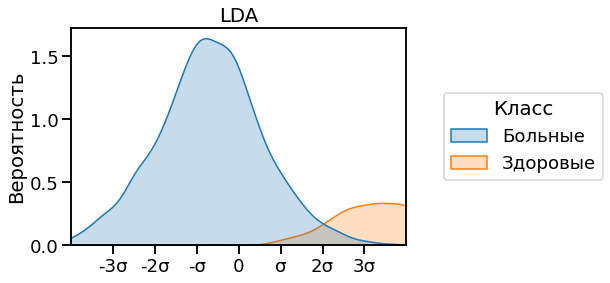

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(926, 1) 926
DETECT: 0.9062757049604669
SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


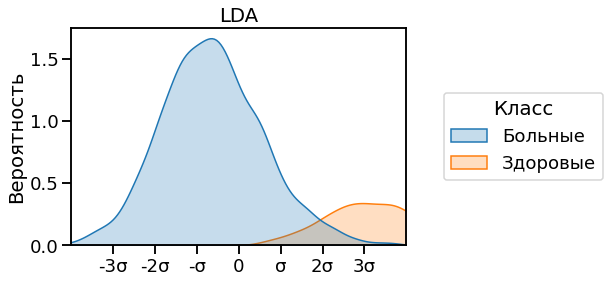

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(926, 1) 926
DETECT: 0.910528598036978
SRC features shape: (5064, 60)
Shape after delete noise: (4755, 60)
6.1% дальше, чем 3std
[98, 94, 95, 83, 93, 97] % по классам


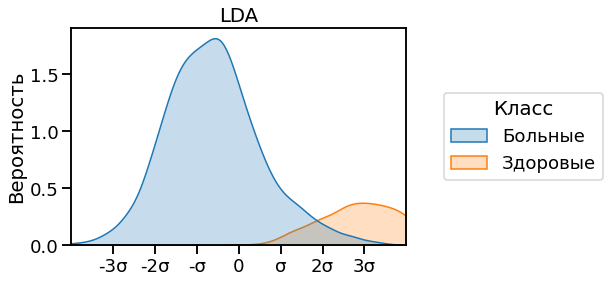

SRC features shape: (930, 60)
Shape after delete noise: (926, 60)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
(926, 1) 926
DETECT: 0.901793167677173


In [44]:
LDA_CLASS(file, 8, 68, 'long', 'local')
LDA_CLASS(file, 8, 68, 'middle', 'local')
LDA_CLASS(file, 8, 68, 'short', 'local')

LDA_DETECT(file, 8, 68, 'long', 'local')
LDA_DETECT(file, 8, 68, 'middle', 'local')
LDA_DETECT(file, 8, 68, 'short', 'local')

SRC features shape: (5064, 60)
Shape after delete noise: (4776, 60)
5.6% дальше, чем 3std
[95, 97, 88, 90, 94, 99] % по классам
(6, 3, 5, 4, 745)
(6, 3, 5)
(18, 5)
(18, 18)


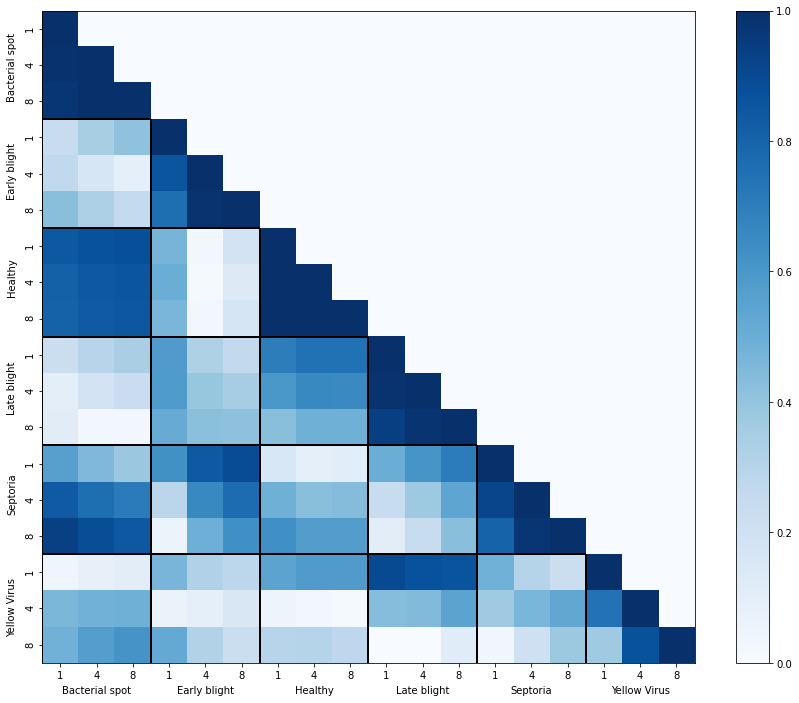

In [384]:
file = os.path.join(os.getcwd(), '..\\data\\local\\train\\R.pth') 
data = load_data(file)

d = np.reshape(data, (6, data.shape[1], 5, 3, 4))
d = np.transpose(d, (0, 3, 2, 4, 1))
print(d.shape)
d = np.mean(d, axis=(-1, -2))
print(d.shape)
d = np.reshape(d, (6*3, 5))
print(d.shape)
cos = abs(cosine_similarity(d, d))
print(cos.shape)

plot_cos_matrix(cos)

# ALL 

SRC features shape: (5064, 68)
Shape after delete noise: (4519, 68)
10.7% дальше, чем 3std
[81, 95, 88, 87, 83, 99] % по классам


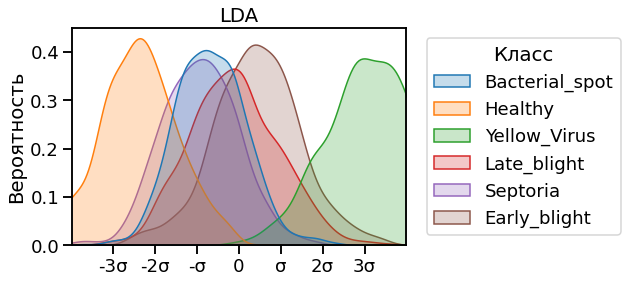

SRC features shape: (930, 68)
Shape after delete noise: (924, 68)
0.6% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.20296667110392597
SRC features shape: (5064, 68)
Shape after delete noise: (4519, 68)
10.7% дальше, чем 3std
[81, 95, 88, 87, 83, 99] % по классам


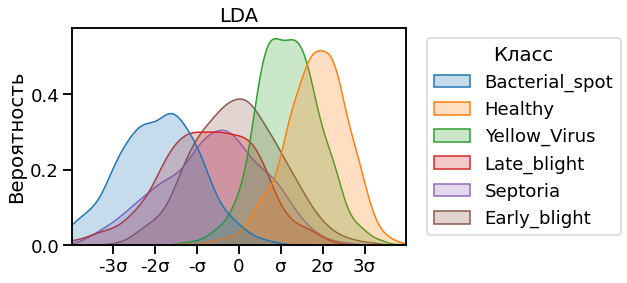

SRC features shape: (930, 68)
Shape after delete noise: (924, 68)
0.6% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.13727152444968632
SRC features shape: (5064, 68)
Shape after delete noise: (4519, 68)
10.7% дальше, чем 3std
[81, 95, 88, 87, 83, 99] % по классам


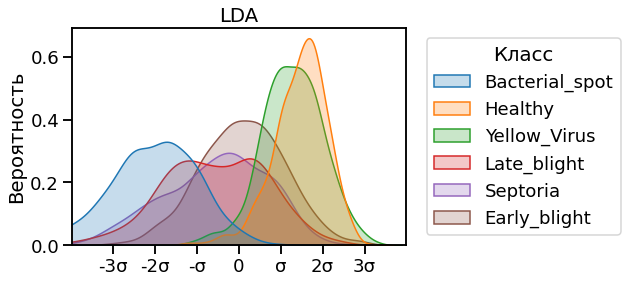

SRC features shape: (930, 68)
Shape after delete noise: (924, 68)
0.6% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.11830861195500157


In [53]:
file = os.path.join(os.getcwd(), '..\\data\\global\\train\\R.pth') 

LDA_CLASS(file, 0, 68, 'long', 'global', True)
LDA_CLASS(file, 0, 68, 'middle', 'global', True)
LDA_CLASS(file, 0, 68, 'short', 'global', True)

SRC features shape: (5064, 68)
Shape after delete noise: (4611, 68)
8.9% дальше, чем 3std
[90, 93, 95, 82, 87, 97] % по классам


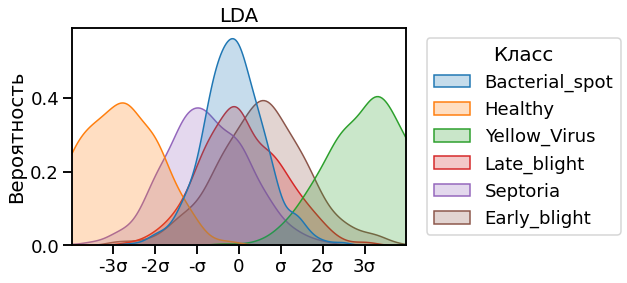

SRC features shape: (930, 68)
Shape after delete noise: (926, 68)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.24728206098334166
SRC features shape: (5064, 68)
Shape after delete noise: (4611, 68)
8.9% дальше, чем 3std
[90, 93, 95, 82, 87, 97] % по классам


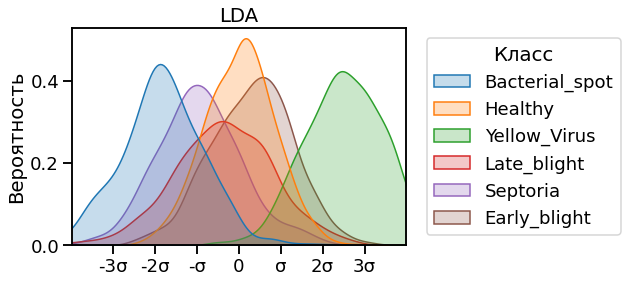

SRC features shape: (930, 68)
Shape after delete noise: (926, 68)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.18247986278116793
SRC features shape: (5064, 68)
Shape after delete noise: (4611, 68)
8.9% дальше, чем 3std
[90, 93, 95, 82, 87, 97] % по классам


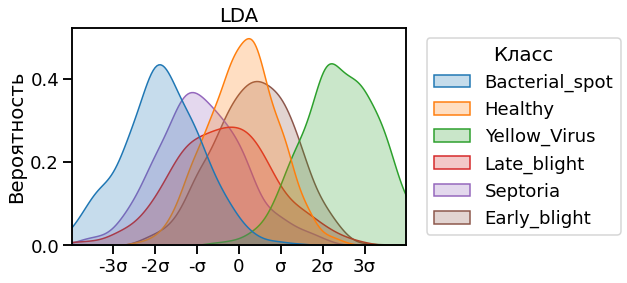

SRC features shape: (930, 68)
Shape after delete noise: (926, 68)
0.4% дальше, чем 5std
[18, 18, 17, 18, 18, 18] % по классам
CLAS: 0.15769856211145325


In [54]:
file = os.path.join(os.getcwd(), '..\\data\\local\\train\\R.pth') 

LDA_CLASS(file, 0, 68, 'long', 'local', True)
LDA_CLASS(file, 0, 68, 'middle', 'local', True)
LDA_CLASS(file, 0, 68, 'short', 'local', True)